In [1]:
import torch
from torch import nn, optim
from neurodiffeq import diff
from neurodiffeq.networks import FCNN, SinActv
from neurodiffeq.temporal import generator_2dspatial_rectangle, generator_2dspatial_segment, generator_temporal
from neurodiffeq.temporal import FirstOrderInitialCondition, BoundaryCondition
from neurodiffeq.temporal import SingleNetworkApproximator2DSpatialSystem, Approximator
from neurodiffeq.temporal import MonitorMinimal
from neurodiffeq.temporal import _solve_2dspatial
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

In [2]:
# torch.set_default_tensor_type('torch.cuda.DoubleTensor')
# torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.DoubleTensor')

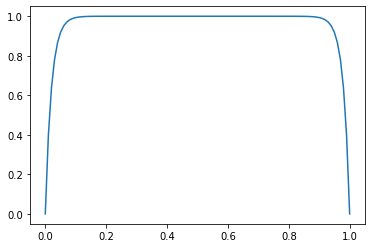

In [3]:
%matplotlib inline
def u_T_approximation(x):
    A = 50. # make A larger, then our network refuse to converge
    return (1-torch.exp(-A*x))*(1-torch.exp(A*(x-1)))
x = torch.linspace(0, 1, 100)
y = u_T_approximation(x)
x = x.detach().cpu().numpy()
y = y.detach().cpu().numpy()
plt.plot(x, y);

In [4]:
class LidDrivenCavityApproximator(Approximator):
    def __init__(self):
        self.single_network = FCNN(
            n_input_units=2, 
            n_hidden_units=256,
            n_hidden_layers=1, 
            n_output_units=3, 
            actv=nn.Tanh
        )

    def __call__(self, xx, yy):
        xx = torch.unsqueeze(xx, dim=1)
        yy = torch.unsqueeze(yy, dim=1)
        xy = torch.cat((xx, yy), dim=1)
        xy = torch.cat((xx, yy), dim=1)
        uvp = self.single_network(xy)
        uu = torch.squeeze(uvp[:, 0])
        vv = torch.squeeze(uvp[:, 1])
        pp = torch.squeeze(uvp[:, 2])
        
        xx = torch.squeeze(xx, dim=1)
        yy = torch.squeeze(yy, dim=1)
        uu = xx*(1-xx)*yy*(1-yy)*uu + yy*u_T_approximation(xx)
        vv = xx*(1-xx)*yy*(1-yy)*vv
        pp = (1-torch.exp(-xx))*(1-torch.exp(-yy))*pp
        return uu, vv, pp

    def parameters(self):
        return self.single_network.parameters()

    def calculate_loss(self, xx, yy):
        uu = self.__call__(xx, yy)

        equation_mse = sum(
            torch.mean(eq**2)
            for eq in self.pde(*uu, xx, yy)
        )

        return equation_mse

    def calculate_metrics(self, xx, yy, metrics):
        uu = self.__call__(xx, yy)

        return {
            metric_name: metric_func(*uu, xx, yy)
            for metric_name, metric_func in metrics.items()
        }
    
    @staticmethod
    def pde(u, v, p, x, y):
        RE = 100.0
        momentum_x = u*diff(u, x) + v*diff(u, y) + diff(p, x) - 1/RE * (diff(u, x, order=2) + diff(u, y, order=2))
        momentum_y = u*diff(v, x) + v*diff(v, y) + diff(p, y) - 1/RE * (diff(v, x, order=2) + diff(v, y, order=2))
        continuity = diff(u, x) + diff(v, y)
        return momentum_x, momentum_y, continuity

In [5]:
# training set and validation set
train_gen_spatial = generator_2dspatial_rectangle(
    size=(64, 64), x_min=0.0, x_max=1.0, y_min=0.0, y_max=1.0
)
valid_gen_spatial = generator_2dspatial_rectangle(
    size=(10, 10), x_min=0.0, x_max=1.0, y_min=0.0, y_max=1.0, random=False
)
fcnn_approximator = LidDrivenCavityApproximator()
adam = optim.Adam(fcnn_approximator.parameters(), lr=0.001)

<IPython.core.display.Javascript object>


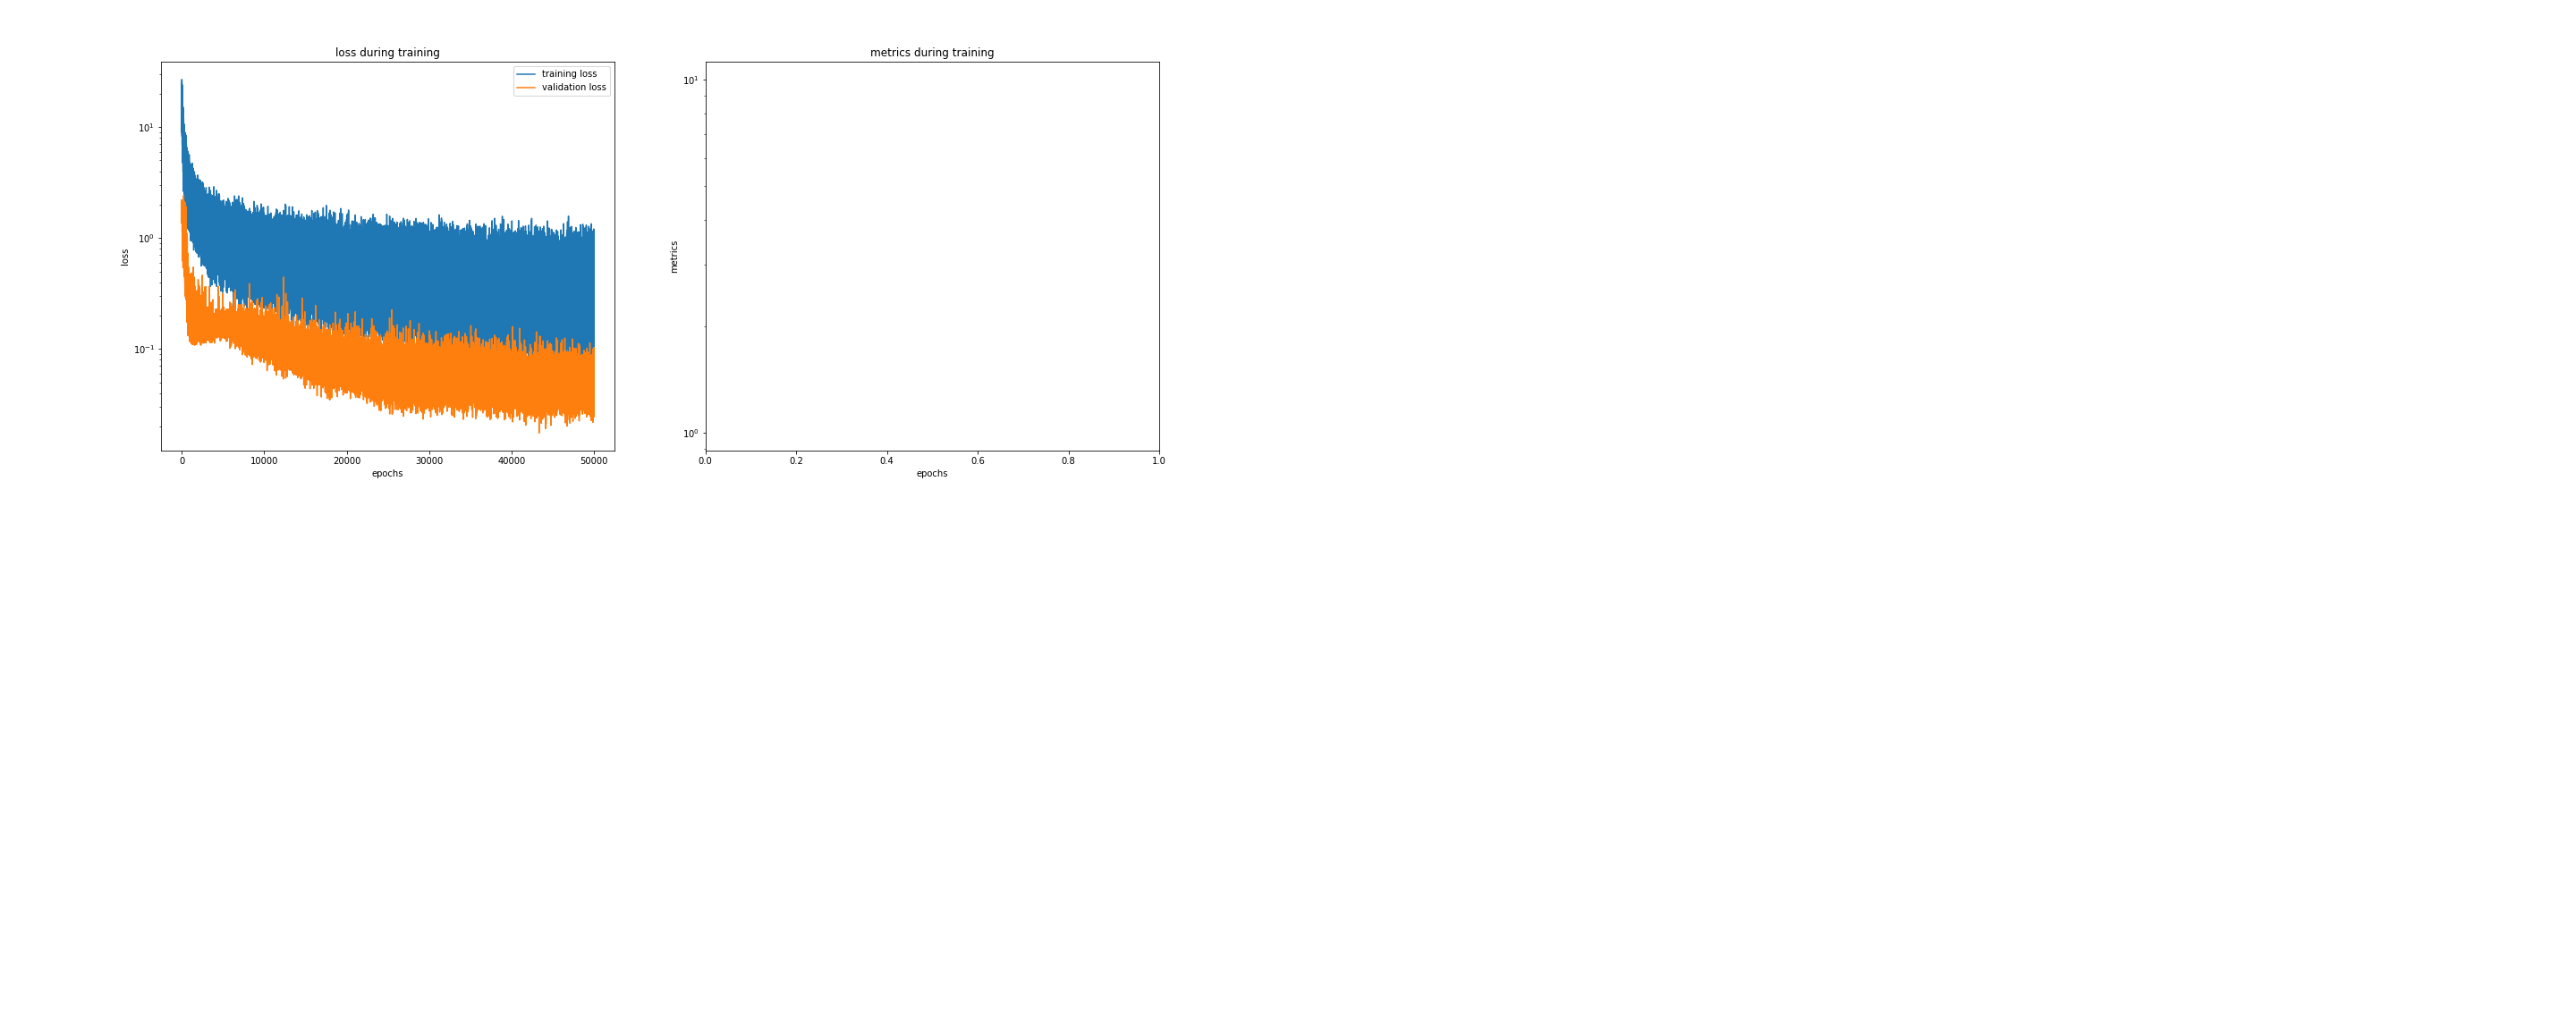

In [6]:
%matplotlib notebook
lid_driven_cavity_solution, _ = _solve_2dspatial(
    train_generator_spatial=train_gen_spatial,
    valid_generator_spatial=valid_gen_spatial,
    approximator=fcnn_approximator,
    optimizer=adam,
    batch_size=1024,
    max_epochs=50000,
    shuffle=True,
    metrics={},
    monitor=MonitorMinimal(check_every=10)
)
%matplotlib inline

In [7]:
torch.save(lid_driven_cavity_solution.single_network, 'ldc_nn_256tanhx1_re100.pt')

In [7]:
lid_driven_cavity_solution = fcnn_approximator
lid_driven_cavity_solution.single_network = torch.load('ldc_nn_256tanhx1_re100.pt', map_location=torch.device('cpu'))

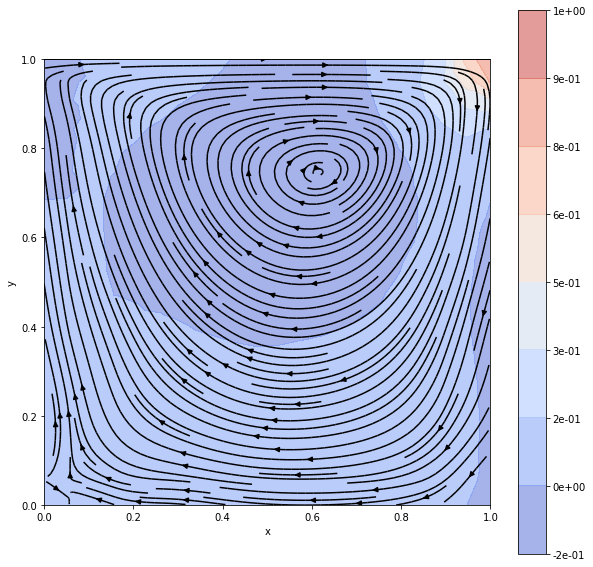

In [9]:
n_grid = 20

xx, yy = torch.meshgrid(torch.linspace(0, 1, n_grid), torch.linspace(0, 1, n_grid))
xx = xx.flatten()
yy = yy.flatten()
uu, vv, pp = lid_driven_cavity_solution(xx, yy)

xx = xx.cpu().detach().numpy()
yy = yy.cpu().detach().numpy()
uu = uu.cpu().detach().numpy()
vv = vv.cpu().detach().numpy()
pp = pp.cpu().detach().numpy()

fig = plt.figure(figsize=(10, 10))
ax = plt.gca()

triang = tri.Triangulation(xx, yy)
contour = ax.tricontourf(triang, pp, cmap='coolwarm', alpha=0.5)
fig.colorbar(contour, format='%.0e', ax=ax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal', adjustable='box')

xx = xx.reshape(n_grid, n_grid).T
yy = yy.reshape(n_grid, n_grid).T
uu = uu.reshape(n_grid, n_grid).T
vv = vv.reshape(n_grid, n_grid).T
ax.streamplot(xx, yy, uu, vv, density=[2, 2], color='black')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plt.show()

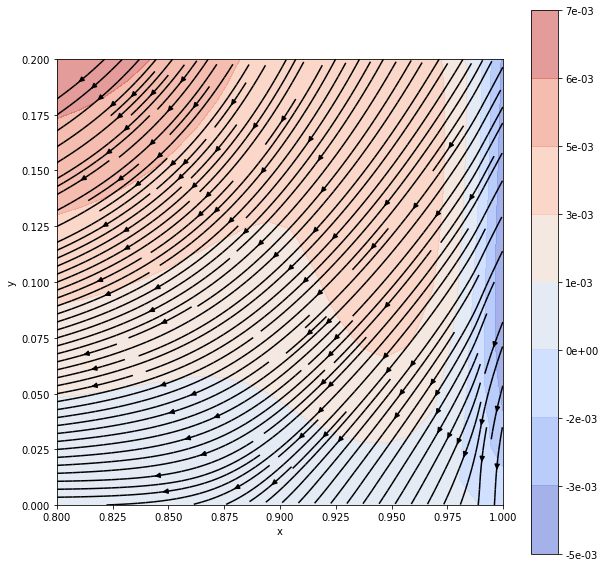

In [15]:
n_grid = 20

xx, yy = torch.meshgrid(torch.linspace(0.8, 1.0, n_grid), torch.linspace(0.0, 0.2, n_grid))
xx = xx.flatten()
yy = yy.flatten()
uu, vv, pp = lid_driven_cavity_solution(xx, yy)

xx = xx.cpu().detach().numpy()
yy = yy.cpu().detach().numpy()
uu = uu.cpu().detach().numpy()
vv = vv.cpu().detach().numpy()
pp = pp.cpu().detach().numpy()

fig = plt.figure(figsize=(10, 10))
ax = plt.gca()

triang = tri.Triangulation(xx, yy)
contour = ax.tricontourf(triang, pp, cmap='coolwarm', alpha=0.5)
fig.colorbar(contour, format='%.0e', ax=ax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal', adjustable='box')

xx = xx.reshape(n_grid, n_grid).T
yy = yy.reshape(n_grid, n_grid).T
uu = uu.reshape(n_grid, n_grid).T
vv = vv.reshape(n_grid, n_grid).T
ax.streamplot(xx, yy, uu, vv, density=[2, 2], color='black')
ax.set_xlim(0.8, 1.0)
ax.set_ylim(0.0, 0.2)

plt.show()

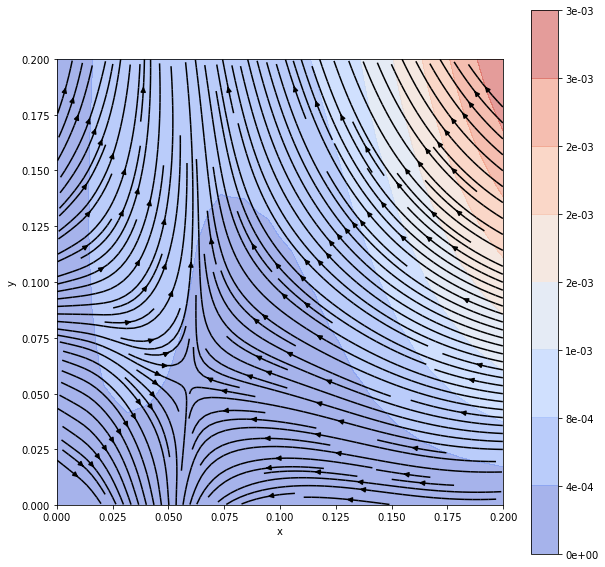

In [16]:
n_grid = 20

xx, yy = torch.meshgrid(torch.linspace(0.0, 0.2, n_grid), torch.linspace(0.0, 0.2, n_grid))
xx = xx.flatten()
yy = yy.flatten()
uu, vv, pp = lid_driven_cavity_solution(xx, yy)

xx = xx.cpu().detach().numpy()
yy = yy.cpu().detach().numpy()
uu = uu.cpu().detach().numpy()
vv = vv.cpu().detach().numpy()
pp = pp.cpu().detach().numpy()

fig = plt.figure(figsize=(10, 10))
ax = plt.gca()

triang = tri.Triangulation(xx, yy)
contour = ax.tricontourf(triang, pp, cmap='coolwarm', alpha=0.5)
fig.colorbar(contour, format='%.0e', ax=ax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal', adjustable='box')

xx = xx.reshape(n_grid, n_grid).T
yy = yy.reshape(n_grid, n_grid).T
uu = uu.reshape(n_grid, n_grid).T
vv = vv.reshape(n_grid, n_grid).T
ax.streamplot(xx, yy, uu, vv, density=[2, 2], color='black')
ax.set_xlim(0.0, 0.2)
ax.set_ylim(0.0, 0.2)

plt.show()

In [8]:
y = torch.linspace(0, 1, 100)
x_ = torch.ones_like(y) * 0.5
u, _, _ = lid_driven_cavity_solution(x_, y)
y = y.detach().cpu().numpy()
u = u.detach().cpu().numpy()

y_ref = np.array([
    1.0000, 0.9766, 0.9688, 0.9609, 0.9531, 0.8516,
    0.7344, 0.6172, 0.5000, 0.4531, 0.2813, 0.1719,
    0.1016, 0.0703, 0.0625, 0.0547, 0.0000,
])
u_ref = np.array([
    1.00000, 0.84123, 0.78871, 0.73722, 0.68717, 0.23151, 
    0.00332, -.13641, -.20581, -.21090, -.15662, -.10150,
    -.06434, -.04775, -.04192, -.03717, 0.00000,
])

x = torch.linspace(0, 1, 100)
y_ = torch.ones_like(x) * 0.5
_, v, _ = lid_driven_cavity_solution(x, y_)
x = x.detach().cpu().numpy()
v = v.detach().cpu().numpy()

x_ref = np.array([
    1.0000, 0.9688, 0.9609, 0.9531, 0.9453, 0.9063,
    0.8594, 0.8047, 0.5000, 0.2344, 0.2266, 0.1563,
    0.0938, 0.0781, 0.0703, 0.0625, 0.0000,
])

v_ref = np.array([
    0.00000, -.05906, -.07391, -.08864, -.10313, -.16914,
    -.22445, -.24533, 0.05454, 0.17527, 0.17507, 0.16077,
    0.12317, 0.10890, 0.10091, 0.09233, 0.00000,
])

<IPython.core.display.Javascript object>


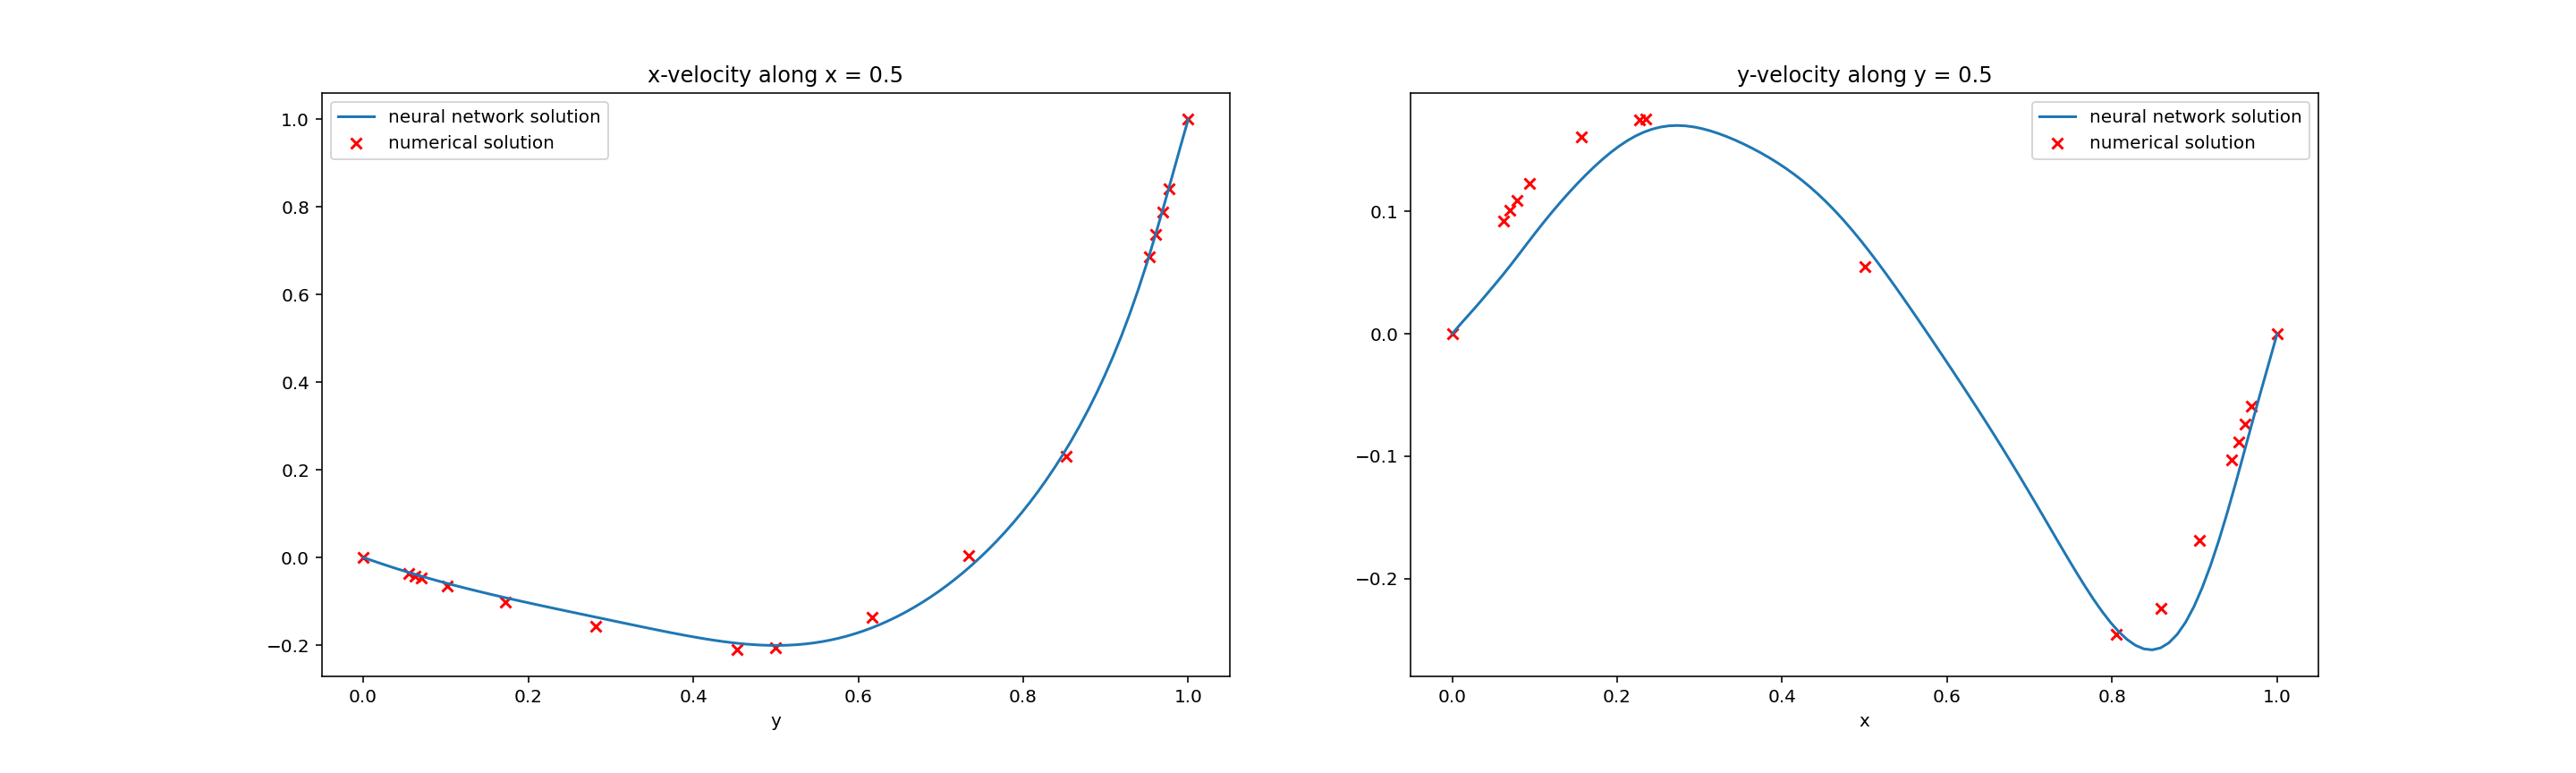

In [12]:
%matplotlib notebook
fig = plt.figure(figsize=(20, 6))

ax = fig.add_subplot(121)
ax.plot(y, u, label='neural network solution')
ax.scatter(y_ref, u_ref, marker='x', color='red', label='numerical solution')
ax.set_xlabel('y')
ax.set_title('x-velocity along x = 0.5')
plt.legend()

ax = fig.add_subplot(122)
ax.plot(x, v, label='neural network solution')
ax.scatter(x_ref, v_ref, marker='x', color='red', label='numerical solution')
ax.set_xlabel('x')
ax.set_title('y-velocity along y = 0.5')
plt.legend();